In [1]:
%load_ext autoreload

In [2]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

In [3]:
%autoreload

In [4]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [5]:
data_dir = os.path.join('data', '1.2')

In [6]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFU3UFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUUSUUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':3.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

# true_tps = np.array([[[0.8, 0.001],
#   [0.1, 0.],
#   [0.0, 0.],
#   [0.1, 0.],
#   [0.0, 0.999]],

#  [[0.1, 0.],
#   [0.8, 0.001],
#   [0.1, 0.],
#   [0.0, 0.],
#   [0.0, 0.999]],

#  [[0.0, 0.],
#   [0.1, 0.],
#   [0.8, 0.001],
#   [0.1, 0.],
#   [0.0, 0.999]],

#  [[0.1, 0.],
#   [0.0, 0.],
#   [0.1, 0.],
#   [0.8, 0.001],
#   [0.0, 0.999]],

#  [[0., 0.],
#   [0., 0.],
#   [0., 0.],
#   [0., 0.],
#   [1., 1.]]])

true_tps = np.array([[[1.0, 0.0],
  [0.0, 0.],
  [0.0, 0.],
  [0.0, 0.],
  [0.0, 1.0]],

 [[0.0, 0.],
  [1.0, 0.0],
  [0.0, 0.],
  [0.0, 0.],
  [0.0, 1.0]],

 [[0.0, 0.],
  [0.0, 0.],
  [1.0, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.0, 0.],
  [0.0, 0.],
  [1.0, 0.0],
  [0.0, 1.0]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [7]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [8]:
# temperature = 1/(reward_normalizer)
# print(temperature)

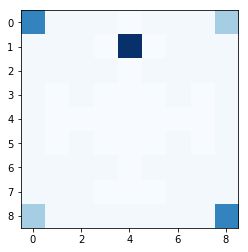

In [9]:
plt.imshow(reward_map, cmap="Blues")

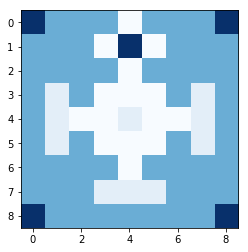

In [10]:
plt.imshow(texture_map, cmap="Blues")

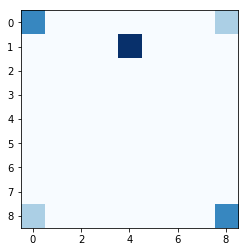

In [11]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [12]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [57]:
mdp.t_mat

array([[[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.8  ,
         0.1  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.1  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.1  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.1  ,
         0.8  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   

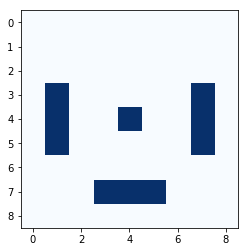

In [13]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [14]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [15]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [16]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = logsumexp(prevQ, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [17]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [18]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [19]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


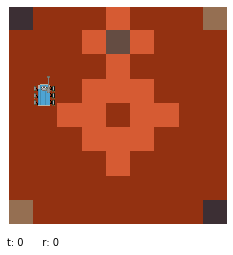

[42.15836629 39.83081718 39.6380362  42.8984153  41.30315893]
3
[0.27032866 0.02636637 0.02174336 0.56661921 0.1149424 ]
(1, 3) b'S'
(1, 2) b'F'


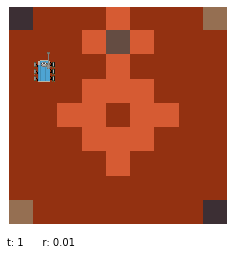

[44.51558075 41.70849184 41.94495987 45.11472976 43.47733672]
3
[0.30197674 0.01823351 0.02309761 0.54976945 0.10692268]
(1, 2) b'F'
(2, 2) b'F'


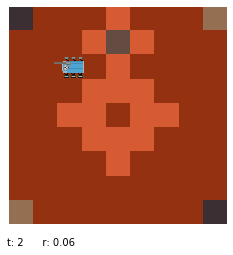

[43.02121768 39.47719856 38.3469184  42.6599477  41.56318543]
0
[0.50820405 0.01468555 0.00474259 0.35411193 0.11825588]
(2, 2) b'F'
(1, 2) b'F'


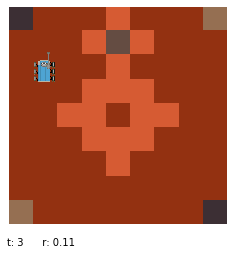

[44.51558075 41.70849184 41.94495987 45.11472976 43.47733672]
3
[0.30197674 0.01823351 0.02309761 0.54976945 0.10692268]
(1, 2) b'F'
(2, 2) b'F'


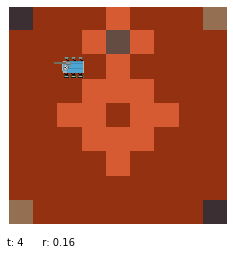

[43.02121768 39.47719856 38.3469184  42.6599477  41.56318543]
0
[0.50820405 0.01468555 0.00474259 0.35411193 0.11825588]
(2, 2) b'F'
(1, 2) b'F'


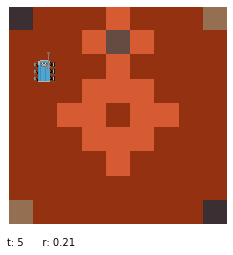

[44.51558075 41.70849184 41.94495987 45.11472976 43.47733672]
3
[0.30197674 0.01823351 0.02309761 0.54976945 0.10692268]
(1, 2) b'F'
(1, 1) b'F'


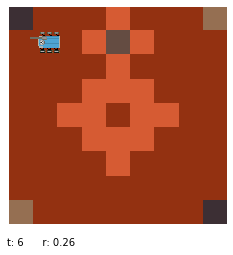

[47.13529965 43.85464451 43.65063416 47.10583693 45.60095633]
0
[0.44349204 0.0166769  0.01359925 0.43061616 0.09561565]
(1, 1) b'F'
(0, 1) b'F'


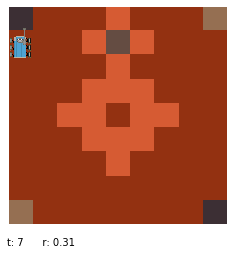

[47.12754977 45.07894661 46.02686084 49.80537432 47.54179157]
3
[0.05705099 0.00735472 0.01897755 0.83028586 0.08633088]
(0, 1) b'F'
(8, 1) b'F'


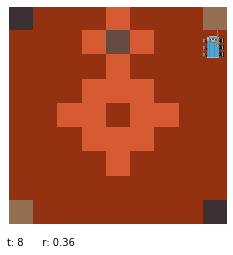

[45.48815056 44.80142337 47.45448965 49.09215962 46.9768175 ]
3
[0.0200706  0.01009993 0.14339383 0.73749913 0.08893651]
(8, 1) b'F'
(8, 0) b'1'


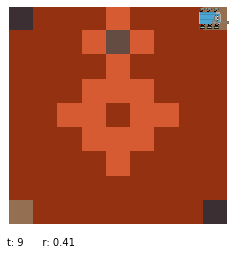

[48.39675434 48.39747377 51.36379002 51.3641104  50.83699212]
2
[0.01910177 0.01911552 0.37122812 0.37134707 0.21920752]
(8, 0) b'1'
(8, 1) b'F'


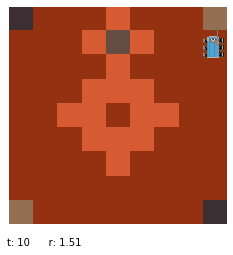

[45.48815056 44.80142337 47.45448965 49.09215962 46.9768175 ]
3
[0.0200706  0.01009993 0.14339383 0.73749913 0.08893651]
(8, 1) b'F'
(8, 0) b'1'


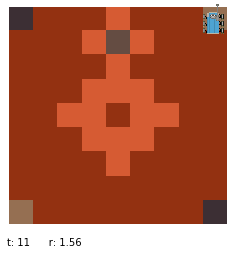

[48.39675434 48.39747377 51.36379002 51.3641104  50.83699212]
3
[0.01910177 0.01911552 0.37122812 0.37134707 0.21920752]
(8, 0) b'1'
(8, 8) b'2'


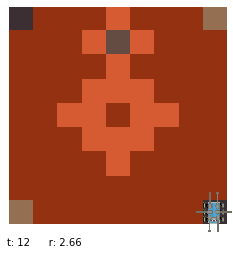

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


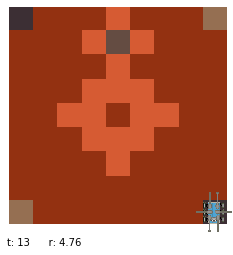

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


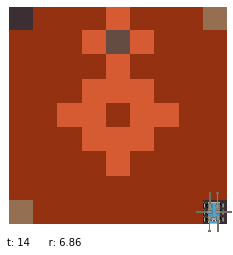

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


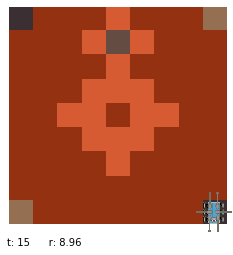

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


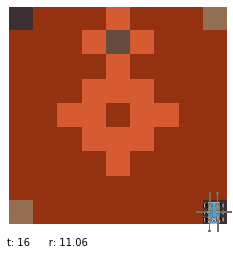

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


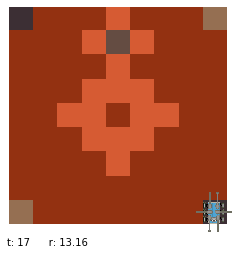

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


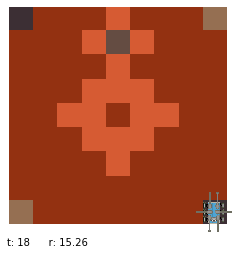

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


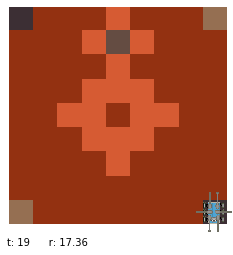

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


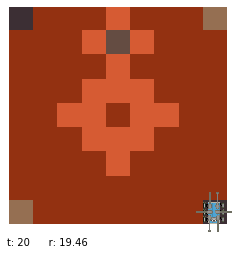

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


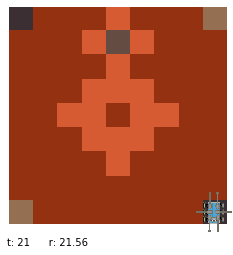

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


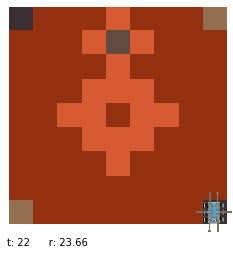

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


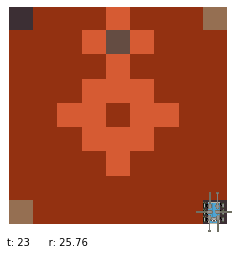

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


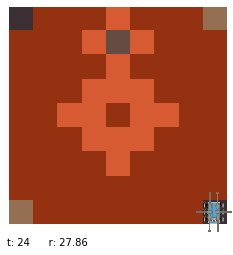

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


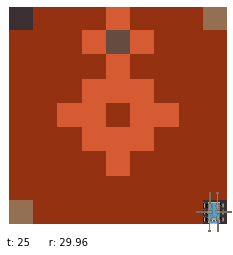

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


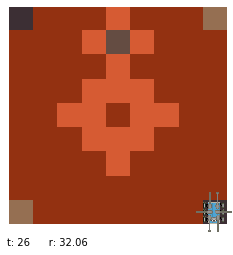

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


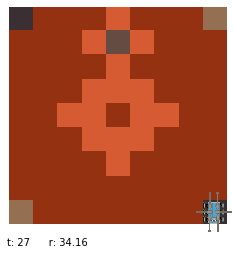

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


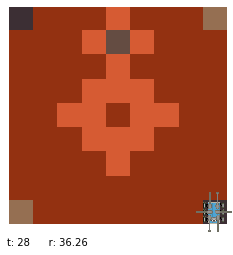

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


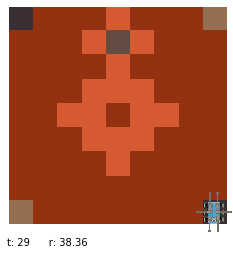

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


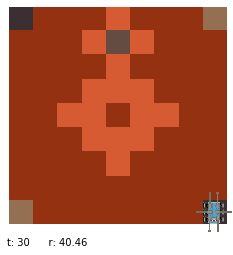

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


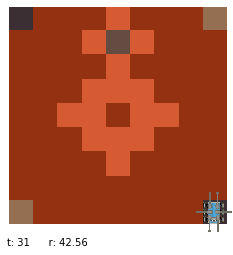

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


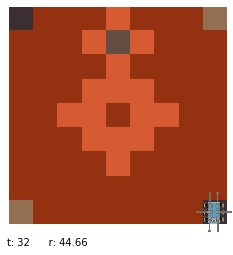

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


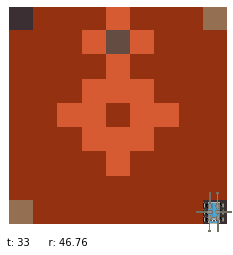

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


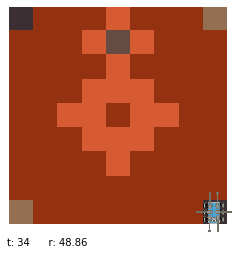

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


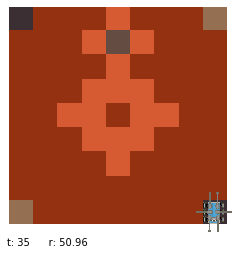

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


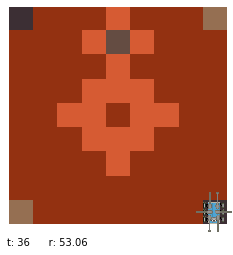

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


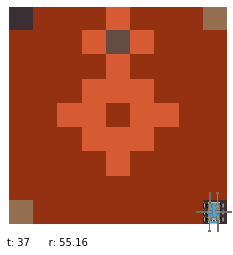

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


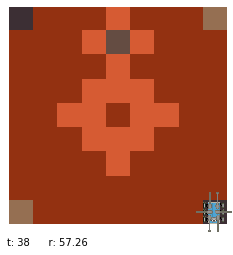

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


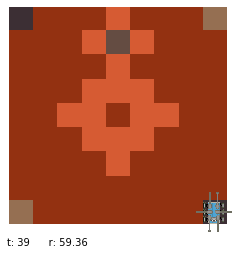

[49.81871126 51.61277439 51.61317867 49.81936439 52.73511328]
4
[0.03076407 0.1850101  0.18508491 0.03078416 0.56835676]
(8, 8) b'2'
(8, 8) b'2'


In [20]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# NN IDL

In [21]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
learning_rate = 1e-1
batch_size = 512
sq_td_err_penalty = 1e2
trans_err_penalty = 1e1


q_n_layers = 1
q_layer_size = 16384
q_activation = tf.nn.relu
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 64
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [22]:
n_obs_feats = 2
n_act_dim = 5
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 5

In [23]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [24]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)

    return feat_states, acts_array, rewards, sprimes, tiles

In [25]:
# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [26]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [27]:
sess = tf.Session()

In [28]:
demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [29]:
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

# demo_v_t = tf.reduce_logsumexp(
#   tf.stack([build_mlp(
#     extract_task(demo_obs_t_ph, train_task_idx),
#     n_act_dim, q_scope+'-'+str(train_task_idx), 
#     n_layers=q_n_layers, size=q_layer_size,
#     activation=q_activation, output_activation=q_output_activation,
#     reuse=True
#   ) for train_task_idx in range(n_train_tasks)], axis=0),
#   axis=2)

In [30]:
demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t


neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [31]:
sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [32]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [33]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [34]:
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_max(constraint_q_tp1, axis=2) #- np.log(5) 

In [35]:
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)

In [36]:
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [37]:
sas_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err
adt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err
adt_loss_act_only = neg_avg_act_log_likelihood + sq_td_err_penalty * adt_td_err

In [38]:
sas_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
adt_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
sas_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sg, axis=1)
adt_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sg, axis=1)
sas_td_err_sg = tf.reduce_mean((constraint_q_t - sas_target_sg)**2)
adt_td_err_sg = tf.reduce_mean((constraint_q_t - adt_target_sg)**2)


In [39]:
sas_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(sas_loss)
adt_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(adt_loss)
adt_trans_only_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(neg_avg_adt_log_likelihood)
adt_q_br_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(adt_td_err_sg)
q_nll_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(neg_avg_act_log_likelihood)

In [40]:
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(true_q_err)

true_t_ph = tf.placeholder(tf.float32, [None], name="tt")
true_t_errs = constraint_adt_pred_dir - true_t_ph
true_t_err = tf.reduce_sum((true_t_errs)**2)
true_t_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(true_t_err)

In [41]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", t=None, true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    if update == "adt_brsg":
        [loss_eval] = sess.run([adt_td_err_sg], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
        
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
        
    if update == "true_ts":
        feed_dict[true_t_ph] = true_qs
        [loss_eval] = sess.run([true_t_err], feed_dict=feed_dict)
        update_op = true_t_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)



    return d

# IDL & SERD Experiments

In [42]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [43]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > 4:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [44]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [45]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * 10), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [46]:
# Ensure bad areas have not been visited in exes
# demos = []
# while len(demos) < n_demos:
#     new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
#     more_sas, more_adt = list(zip(*new_demo))
#     if len(set([adt[2] for adt in more_adt])) == 1:
#         demos += [new_demo]
        
# sas_obs, adt_obs = vectorize_rollouts(demos)

# IDL NN

In [47]:
n_training_iters = 1000000

In [48]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [49]:
tf.global_variables_initializer().run(session=sess)

In [61]:
full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
}

In [51]:
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


[('loss', 0.28706023)]


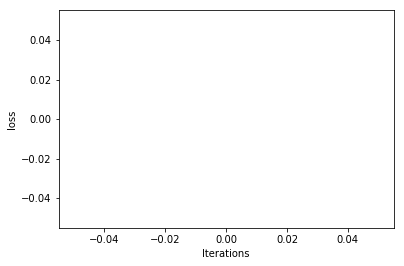

[('loss', 0.25542524)]
[('loss', 0.2448428)]
[('loss', 0.24459496)]
[('loss', 0.24442661)]
[('loss', 0.24440162)]
[('loss', 0.24424314)]
[('loss', 0.24427551)]
[('loss', 0.24412778)]
[('loss', 0.24411142)]
[('loss', 0.24404535)]


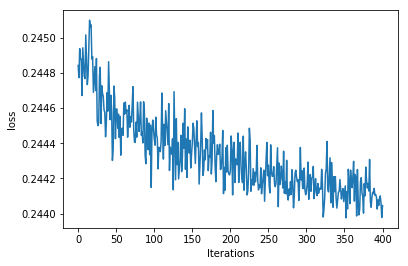

[('loss', 0.24403574)]
[('loss', 0.24399751)]
[('loss', 0.24392737)]
[('loss', 0.24393442)]
[('loss', 0.24395105)]
[('loss', 0.24376722)]
[('loss', 0.24395548)]
[('loss', 0.24395333)]
[('loss', 0.24387996)]
[('loss', 0.24381539)]


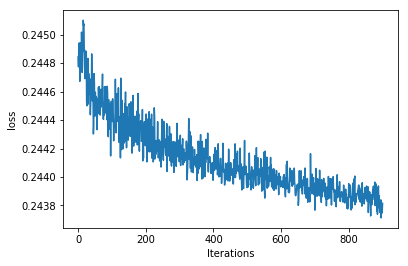

[('loss', 0.24388243)]
[('loss', 0.2437976)]
[('loss', 0.2437993)]
[('loss', 0.24368493)]
[('loss', 0.24370596)]
[('loss', 0.24372484)]
[('loss', 0.24370569)]
[('loss', 0.24368414)]
[('loss', 0.24368408)]
[('loss', 0.2436875)]


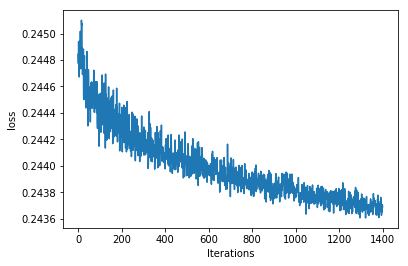

[('loss', 0.24375309)]
[('loss', 0.24368444)]
[('loss', 0.24367519)]
[('loss', 0.24366866)]
[('loss', 0.24357481)]
[('loss', 0.24355231)]
[('loss', 0.2435684)]
[('loss', 0.24364913)]
[('loss', 0.24352396)]
[('loss', 0.24352357)]


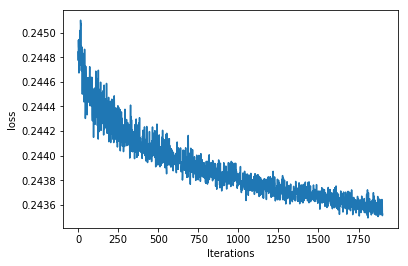

[('loss', 0.24363951)]
[('loss', 0.24346331)]
[('loss', 0.24359246)]
[('loss', 0.24356273)]
[('loss', 0.24348238)]
[('loss', 0.24350174)]
[('loss', 0.24348742)]
[('loss', 0.24354532)]
[('loss', 0.24347447)]
[('loss', 0.24349862)]


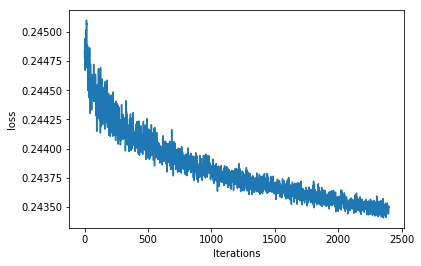

[('loss', 0.24349314)]
[('loss', 0.24345921)]
[('loss', 0.24346495)]
[('loss', 0.24338198)]
[('loss', 0.24338387)]
[('loss', 0.24339658)]
[('loss', 0.24338916)]
[('loss', 0.24335264)]
[('loss', 0.24345064)]
[('loss', 0.24336186)]


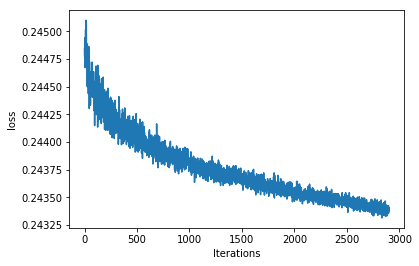

[('loss', 0.24337234)]
[('loss', 0.24331865)]
[('loss', 0.24340564)]
[('loss', 0.24340625)]
[('loss', 0.24333553)]
[('loss', 0.24334459)]
[('loss', 0.24332772)]
[('loss', 0.24326597)]
[('loss', 0.24335688)]
[('loss', 0.24331896)]


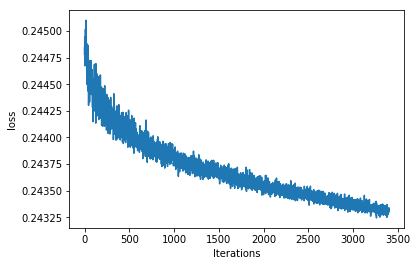

[('loss', 0.24330893)]
[('loss', 0.24335252)]
[('loss', 0.24329068)]
[('loss', 0.24329354)]
[('loss', 0.24329554)]
[('loss', 0.2432545)]
[('loss', 0.243277)]
[('loss', 0.24325809)]
[('loss', 0.24326733)]
[('loss', 0.24323821)]


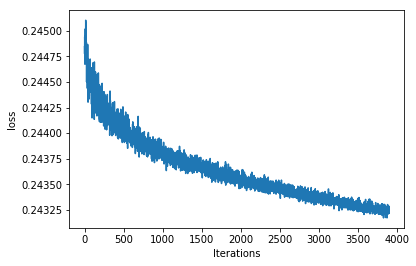

[('loss', 0.24320684)]
[('loss', 0.24323207)]
[('loss', 0.24320152)]
[('loss', 0.24319014)]
[('loss', 0.24319746)]
[('loss', 0.24324301)]
[('loss', 0.2431989)]
[('loss', 0.24318272)]
[('loss', 0.24318947)]
[('loss', 0.24320148)]


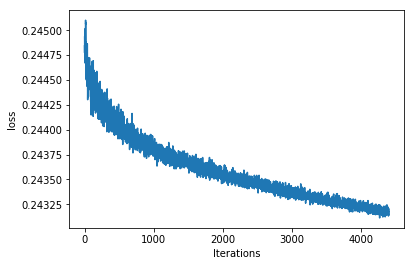

[('loss', 0.24316384)]
[('loss', 0.24317673)]
[('loss', 0.2431595)]
[('loss', 0.2431768)]
[('loss', 0.24314794)]
[('loss', 0.24312843)]
[('loss', 0.24311784)]
[('loss', 0.24311107)]
[('loss', 0.24308372)]
[('loss', 0.24309894)]


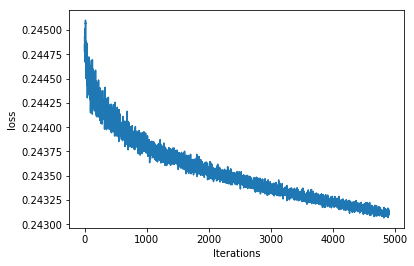

[('loss', 0.24309519)]
[('loss', 0.24308664)]
[('loss', 0.24307635)]
[('loss', 0.24307865)]
[('loss', 0.2431088)]
[('loss', 0.24309105)]
[('loss', 0.24306972)]
[('loss', 0.24307247)]
[('loss', 0.24306583)]
[('loss', 0.24302262)]


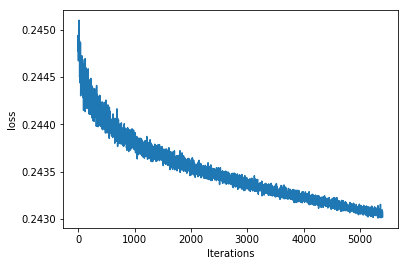

[('loss', 0.24304365)]
[('loss', 0.24305509)]
[('loss', 0.24305885)]
[('loss', 0.24303342)]
[('loss', 0.24302982)]
[('loss', 0.24300101)]
[('loss', 0.24302483)]
[('loss', 0.24301897)]
[('loss', 0.24299914)]
[('loss', 0.24297868)]


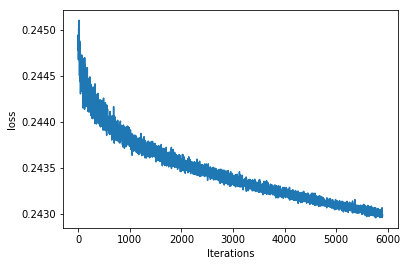

[('loss', 0.24301699)]
[('loss', 0.24301742)]
[('loss', 0.24298868)]
[('loss', 0.24300571)]
[('loss', 0.2430112)]
[('loss', 0.24297918)]
[('loss', 0.2429789)]
[('loss', 0.24297304)]
[('loss', 0.2429371)]
[('loss', 0.24298446)]


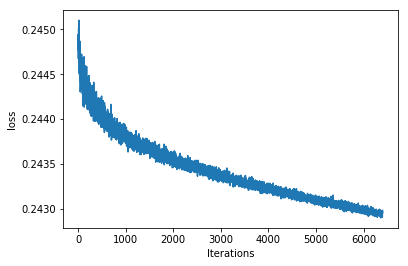

[('loss', 0.24295484)]
[('loss', 0.24292535)]
[('loss', 0.24291538)]
[('loss', 0.2429122)]
[('loss', 0.24290293)]
[('loss', 0.24291077)]
[('loss', 0.24288622)]
[('loss', 0.24292505)]
[('loss', 0.24286686)]
[('loss', 0.24290265)]


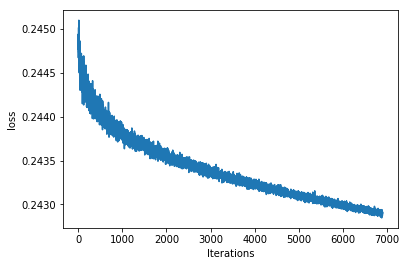

[('loss', 0.24287127)]
[('loss', 0.24285096)]
[('loss', 0.24288143)]
[('loss', 0.24288091)]
[('loss', 0.24288936)]
[('loss', 0.24284981)]
[('loss', 0.24286447)]
[('loss', 0.24283713)]
[('loss', 0.24284314)]
[('loss', 0.24282995)]


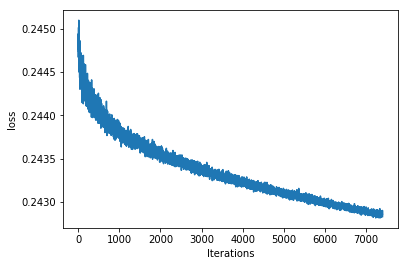

[('loss', 0.24285746)]
[('loss', 0.24284534)]
[('loss', 0.24282339)]
[('loss', 0.24281323)]
[('loss', 0.2428419)]
[('loss', 0.24283142)]
[('loss', 0.2428069)]
[('loss', 0.24281171)]
[('loss', 0.24278545)]
[('loss', 0.24280676)]


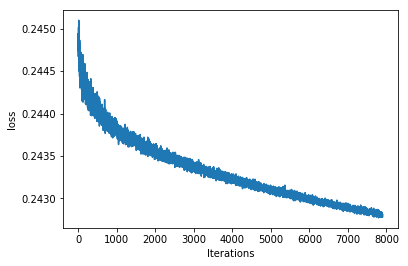

[('loss', 0.24281394)]
[('loss', 0.242844)]
[('loss', 0.24278875)]
[('loss', 0.24280384)]
[('loss', 0.24278335)]
[('loss', 0.24277095)]
[('loss', 0.2427444)]
[('loss', 0.2427873)]
[('loss', 0.24272963)]
[('loss', 0.24279901)]


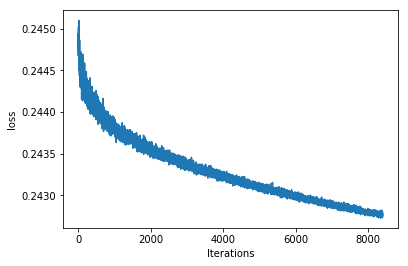

[('loss', 0.24275942)]
[('loss', 0.24272062)]
[('loss', 0.24272572)]
[('loss', 0.24274202)]
[('loss', 0.24272472)]
[('loss', 0.242717)]
[('loss', 0.24271776)]
[('loss', 0.24274896)]
[('loss', 0.24271402)]
[('loss', 0.24272254)]


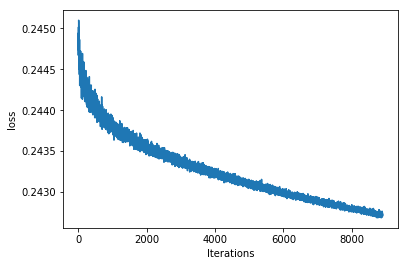

[('loss', 0.24270308)]
[('loss', 0.24268384)]
[('loss', 0.24273063)]
[('loss', 0.24270573)]
[('loss', 0.24269341)]
[('loss', 0.24270816)]
[('loss', 0.24265711)]
[('loss', 0.24269441)]
[('loss', 0.2426675)]
[('loss', 0.24264662)]


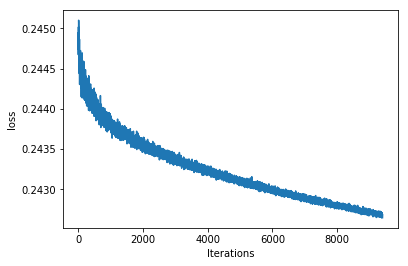

[('loss', 0.24268077)]
[('loss', 0.2426919)]
[('loss', 0.24265547)]
[('loss', 0.24267285)]
[('loss', 0.24263985)]
[('loss', 0.24264807)]
[('loss', 0.24267954)]
[('loss', 0.24265803)]
[('loss', 0.2426611)]
[('loss', 0.24262582)]


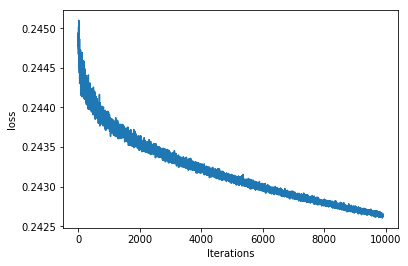

[('loss', 0.24263102)]
[('loss', 0.24261269)]
[('loss', 0.24260391)]
[('loss', 0.24264003)]
[('loss', 0.24263053)]
[('loss', 0.24261634)]
[('loss', 0.24261975)]
[('loss', 0.24261045)]
[('loss', 0.24259499)]
[('loss', 0.24260175)]


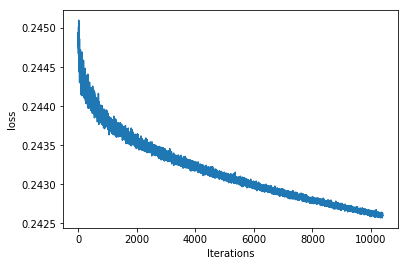

[('loss', 0.2425848)]
[('loss', 0.24260613)]
[('loss', 0.24261637)]
[('loss', 0.2426091)]
[('loss', 0.24257766)]
[('loss', 0.24255612)]
[('loss', 0.24257469)]
[('loss', 0.24255665)]
[('loss', 0.24256149)]
[('loss', 0.24256824)]


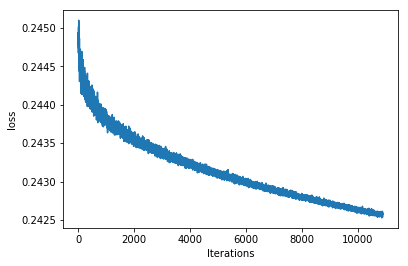

[('loss', 0.24255551)]
[('loss', 0.24255231)]
[('loss', 0.24254072)]
[('loss', 0.24254777)]
[('loss', 0.24255358)]
[('loss', 0.24252777)]
[('loss', 0.24255766)]
[('loss', 0.24254222)]
[('loss', 0.24254796)]
[('loss', 0.24253358)]


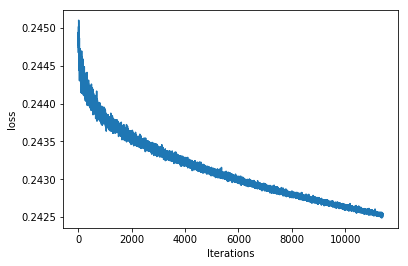

[('loss', 0.24251862)]
[('loss', 0.24252433)]
[('loss', 0.24251269)]
[('loss', 0.24252646)]
[('loss', 0.24248609)]
[('loss', 0.24250166)]
[('loss', 0.24249189)]
[('loss', 0.24249019)]
[('loss', 0.24250738)]
[('loss', 0.24247971)]


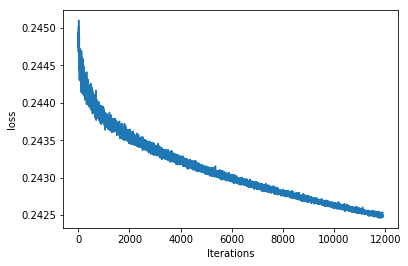

[('loss', 0.24250649)]
[('loss', 0.24247527)]
[('loss', 0.24247813)]
[('loss', 0.24248417)]
[('loss', 0.2425056)]
[('loss', 0.24246466)]
[('loss', 0.24247454)]
[('loss', 0.24243876)]
[('loss', 0.24244694)]
[('loss', 0.2424474)]


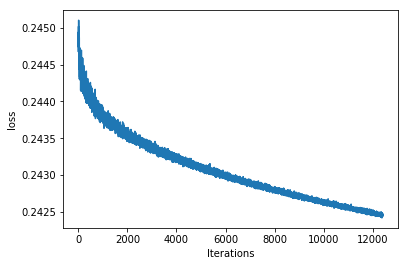

[('loss', 0.24245743)]
[('loss', 0.24244459)]
[('loss', 0.24245575)]
[('loss', 0.24243926)]
[('loss', 0.24242513)]
[('loss', 0.24241468)]
[('loss', 0.24240848)]
[('loss', 0.24240895)]
[('loss', 0.24241924)]
[('loss', 0.24240485)]


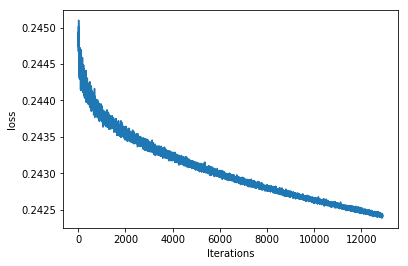

[('loss', 0.24241503)]
[('loss', 0.24240682)]
[('loss', 0.24241473)]
[('loss', 0.24237803)]
[('loss', 0.24239385)]
[('loss', 0.24237931)]
[('loss', 0.24239932)]
[('loss', 0.24239491)]
[('loss', 0.24236853)]
[('loss', 0.24237847)]


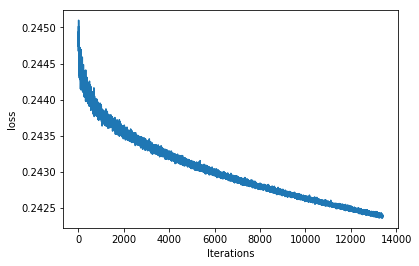

[('loss', 0.24241227)]
[('loss', 0.2423726)]
[('loss', 0.24235052)]
[('loss', 0.24235463)]
[('loss', 0.24236996)]
[('loss', 0.2423698)]
[('loss', 0.24235629)]
[('loss', 0.24233949)]
[('loss', 0.242358)]
[('loss', 0.24234292)]


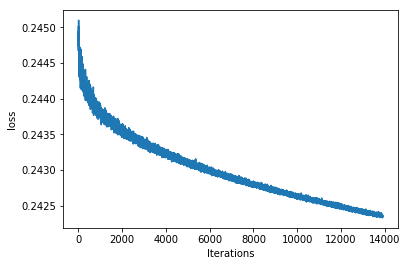

[('loss', 0.24235459)]
[('loss', 0.24236616)]
[('loss', 0.24234912)]
[('loss', 0.2423108)]
[('loss', 0.2423335)]
[('loss', 0.24233186)]
[('loss', 0.24236475)]
[('loss', 0.2423166)]
[('loss', 0.24232545)]
[('loss', 0.24232)]


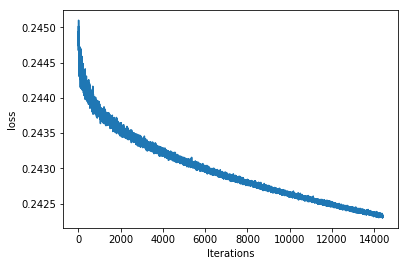

[('loss', 0.24231406)]
[('loss', 0.2423356)]
[('loss', 0.24231718)]
[('loss', 0.24230565)]
[('loss', 0.24229617)]
[('loss', 0.24228606)]
[('loss', 0.2422999)]
[('loss', 0.24228966)]
[('loss', 0.24230023)]
[('loss', 0.24227996)]


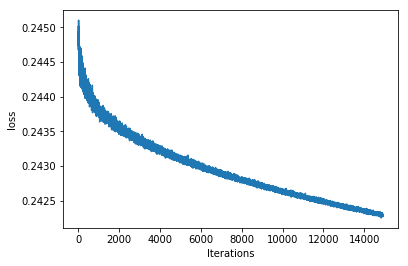

[('loss', 0.2423124)]
[('loss', 0.2422693)]
[('loss', 0.24226199)]
[('loss', 0.24225718)]
[('loss', 0.24228784)]
[('loss', 0.24227536)]
[('loss', 0.24227855)]
[('loss', 0.2422727)]
[('loss', 0.24225017)]
[('loss', 0.24226487)]


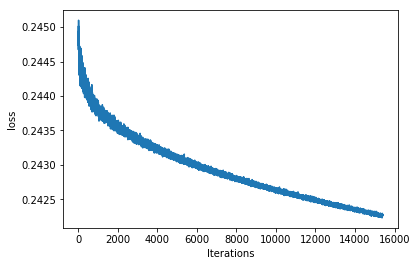

[('loss', 0.24226701)]
[('loss', 0.24223936)]
[('loss', 0.24225657)]
[('loss', 0.24223603)]
[('loss', 0.24225236)]
[('loss', 0.24225408)]
[('loss', 0.24224028)]
[('loss', 0.24224128)]
[('loss', 0.24225996)]
[('loss', 0.24223332)]


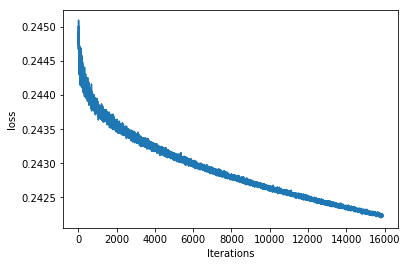

[('loss', 0.24223761)]
[('loss', 0.24222724)]
[('loss', 0.24222213)]
[('loss', 0.2422165)]
[('loss', 0.2422155)]
[('loss', 0.24221645)]
[('loss', 0.2421853)]
[('loss', 0.24219005)]
[('loss', 0.24220192)]
[('loss', 0.24218841)]


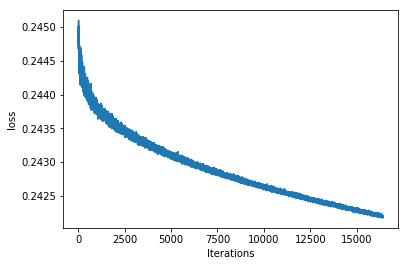

[('loss', 0.24221765)]
[('loss', 0.2422138)]
[('loss', 0.24221775)]
[('loss', 0.2421927)]
[('loss', 0.24217564)]
[('loss', 0.24219187)]
[('loss', 0.24216285)]
[('loss', 0.24218558)]
[('loss', 0.24217388)]
[('loss', 0.2421692)]


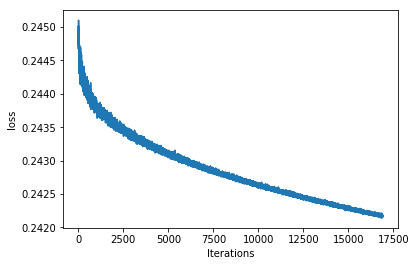

[('loss', 0.24216112)]
[('loss', 0.24216557)]
[('loss', 0.24215327)]
[('loss', 0.24216865)]
[('loss', 0.2421289)]
[('loss', 0.24214628)]
[('loss', 0.24213824)]
[('loss', 0.2421584)]
[('loss', 0.2421391)]
[('loss', 0.242142)]


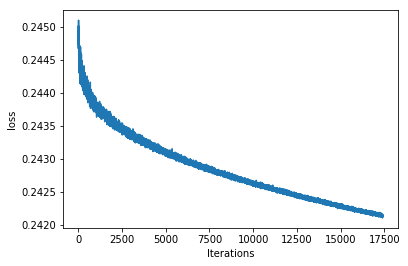

[('loss', 0.2421339)]
[('loss', 0.2421467)]
[('loss', 0.24214056)]
[('loss', 0.24211648)]
[('loss', 0.24212134)]
[('loss', 0.2421214)]
[('loss', 0.2421308)]
[('loss', 0.24211471)]
[('loss', 0.24211764)]
[('loss', 0.2421226)]


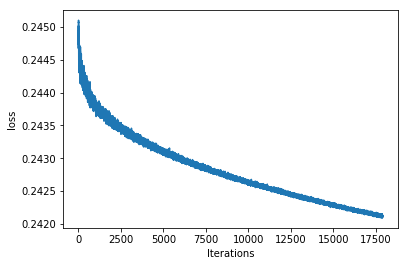

[('loss', 0.24211398)]
[('loss', 0.24212837)]
[('loss', 0.24209738)]
[('loss', 0.24211684)]
[('loss', 0.24208324)]
[('loss', 0.24208339)]
[('loss', 0.24209422)]
[('loss', 0.24207854)]
[('loss', 0.24208613)]
[('loss', 0.24208844)]


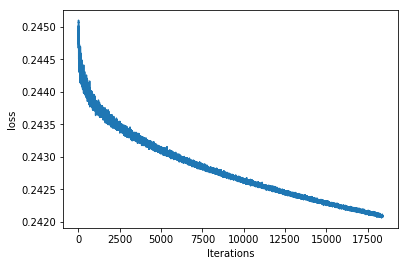

[('loss', 0.24207982)]
[('loss', 0.24207805)]
[('loss', 0.24205852)]
[('loss', 0.24207392)]
[('loss', 0.24206829)]
[('loss', 0.24206094)]
[('loss', 0.24205802)]
[('loss', 0.24207494)]
[('loss', 0.24205923)]
[('loss', 0.24206683)]


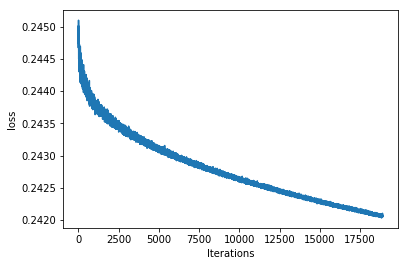

[('loss', 0.24206412)]
[('loss', 0.2420324)]
[('loss', 0.24205697)]
[('loss', 0.24205133)]
[('loss', 0.24207154)]
[('loss', 0.24205773)]
[('loss', 0.24203555)]
[('loss', 0.24204127)]
[('loss', 0.24205108)]
[('loss', 0.24202323)]


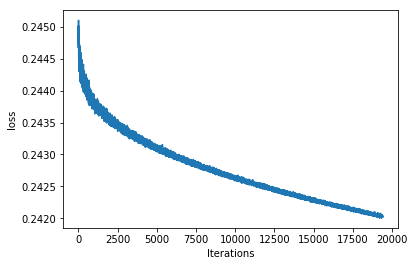

[('loss', 0.24202324)]
[('loss', 0.24202234)]
[('loss', 0.24200767)]
[('loss', 0.24201575)]
[('loss', 0.2420178)]
[('loss', 0.24200903)]
[('loss', 0.2420125)]
[('loss', 0.24203327)]
[('loss', 0.24201885)]
[('loss', 0.24201131)]


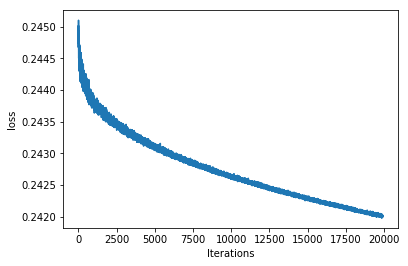

[('loss', 0.24198914)]
[('loss', 0.24199268)]
[('loss', 0.24199598)]
[('loss', 0.24199875)]
[('loss', 0.24198613)]
[('loss', 0.24199697)]
[('loss', 0.24198835)]
[('loss', 0.24199012)]
[('loss', 0.24196155)]
[('loss', 0.24197915)]


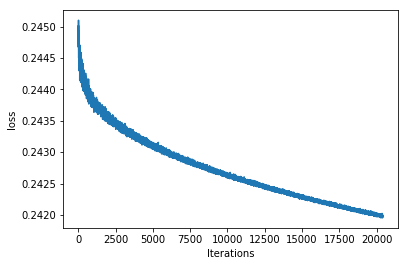

[('loss', 0.24198088)]
[('loss', 0.24197736)]
[('loss', 0.2419585)]
[('loss', 0.24199648)]
[('loss', 0.24196602)]
[('loss', 0.24195917)]
[('loss', 0.241969)]
[('loss', 0.24197318)]
[('loss', 0.24194829)]
[('loss', 0.24194092)]


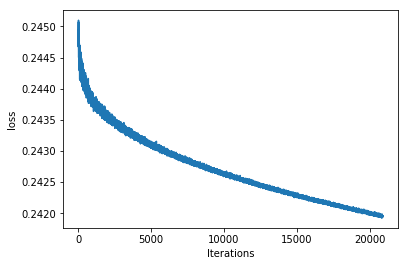

[('loss', 0.2419541)]
[('loss', 0.24194065)]
[('loss', 0.24192679)]
[('loss', 0.24194157)]
[('loss', 0.24194108)]
[('loss', 0.2419391)]
[('loss', 0.24195604)]
[('loss', 0.2419403)]
[('loss', 0.2419047)]
[('loss', 0.2419128)]


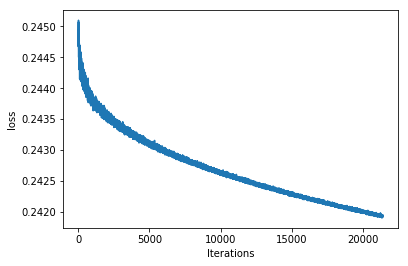

[('loss', 0.24190958)]
[('loss', 0.24191606)]
[('loss', 0.2419124)]
[('loss', 0.24191532)]
[('loss', 0.24192673)]
[('loss', 0.24191476)]
[('loss', 0.24189806)]
[('loss', 0.24193045)]
[('loss', 0.24188973)]
[('loss', 0.24189472)]


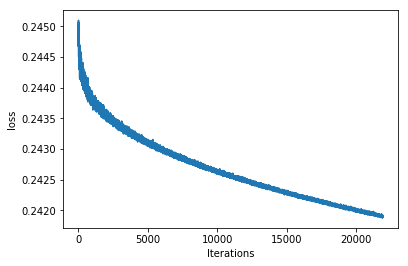

[('loss', 0.24189264)]
[('loss', 0.2419058)]
[('loss', 0.24189122)]
[('loss', 0.24191503)]
[('loss', 0.24191605)]
[('loss', 0.24188447)]
[('loss', 0.24188025)]
[('loss', 0.24187696)]
[('loss', 0.24190278)]
[('loss', 0.24187581)]


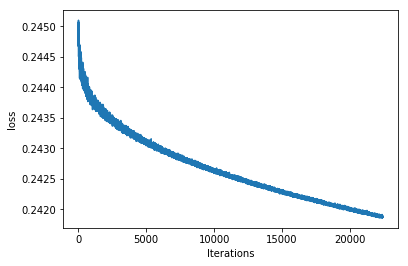

[('loss', 0.2418694)]
[('loss', 0.24184404)]
[('loss', 0.2418468)]
[('loss', 0.24189174)]
[('loss', 0.2418471)]
[('loss', 0.24187256)]
[('loss', 0.24186008)]
[('loss', 0.24185449)]
[('loss', 0.24185766)]
[('loss', 0.24184941)]


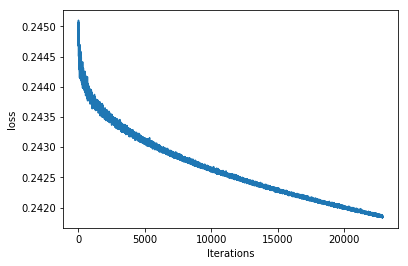

[('loss', 0.24186227)]
[('loss', 0.24182259)]
[('loss', 0.24183835)]
[('loss', 0.24183382)]
[('loss', 0.241836)]
[('loss', 0.24183255)]
[('loss', 0.24184345)]
[('loss', 0.24183264)]
[('loss', 0.24183485)]
[('loss', 0.24181642)]


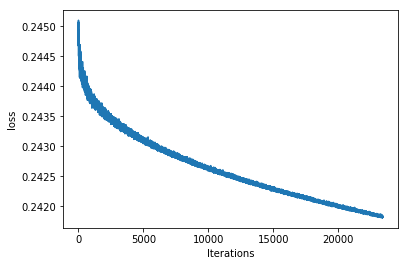

[('loss', 0.24182975)]
[('loss', 0.24182752)]
[('loss', 0.24181646)]
[('loss', 0.24179284)]
[('loss', 0.24181314)]
[('loss', 0.24182281)]
[('loss', 0.24181439)]
[('loss', 0.2418218)]
[('loss', 0.24181941)]
[('loss', 0.2418324)]


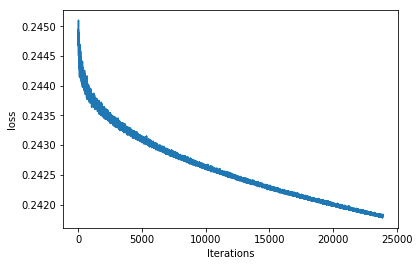

[('loss', 0.24181502)]
[('loss', 0.24178387)]
[('loss', 0.24178019)]
[('loss', 0.24178651)]
[('loss', 0.24180548)]
[('loss', 0.24179362)]
[('loss', 0.24179237)]
[('loss', 0.24178202)]
[('loss', 0.24179405)]
[('loss', 0.24177338)]


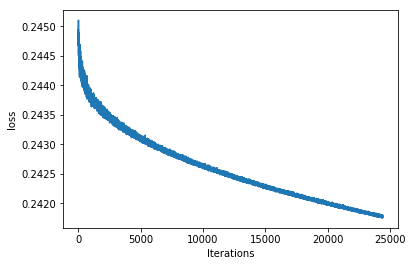

[('loss', 0.24179322)]
[('loss', 0.24178062)]
[('loss', 0.24177238)]
[('loss', 0.2417831)]
[('loss', 0.24176045)]
[('loss', 0.24176876)]
[('loss', 0.24175742)]
[('loss', 0.2417581)]
[('loss', 0.24175632)]
[('loss', 0.24175847)]


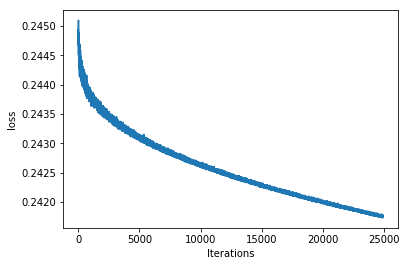

[('loss', 0.24178226)]
[('loss', 0.2417454)]
[('loss', 0.24176174)]
[('loss', 0.24173377)]
[('loss', 0.24173267)]
[('loss', 0.24174286)]
[('loss', 0.24175103)]
[('loss', 0.24172734)]
[('loss', 0.2417274)]
[('loss', 0.24172474)]


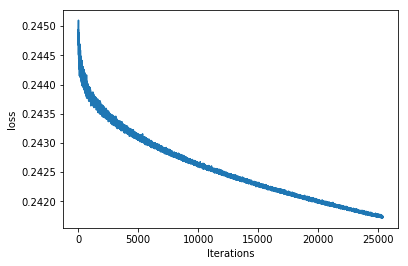

[('loss', 0.24173906)]
[('loss', 0.2417339)]
[('loss', 0.24171165)]
[('loss', 0.2417209)]
[('loss', 0.24170886)]
[('loss', 0.24172911)]
[('loss', 0.24173863)]
[('loss', 0.2417177)]
[('loss', 0.24172695)]
[('loss', 0.24171606)]


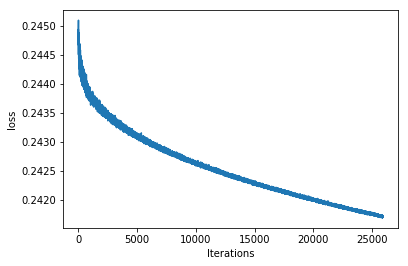

[('loss', 0.24171007)]
[('loss', 0.24170376)]
[('loss', 0.24169552)]
[('loss', 0.2416864)]
[('loss', 0.24170299)]
[('loss', 0.24169444)]
[('loss', 0.24172267)]
[('loss', 0.24169624)]
[('loss', 0.24169324)]
[('loss', 0.2416903)]


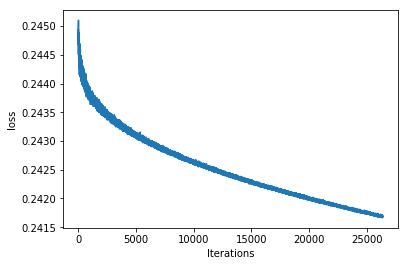

[('loss', 0.24169296)]
[('loss', 0.24169052)]
[('loss', 0.24166527)]
[('loss', 0.24165368)]
[('loss', 0.24167852)]
[('loss', 0.24167499)]
[('loss', 0.24167854)]
[('loss', 0.24165435)]
[('loss', 0.24168311)]
[('loss', 0.24166527)]


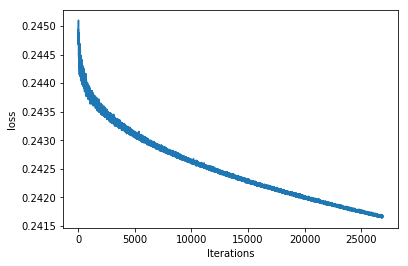

[('loss', 0.24165449)]
[('loss', 0.2416638)]
[('loss', 0.24164534)]
[('loss', 0.24165878)]
[('loss', 0.2416479)]
[('loss', 0.24164675)]
[('loss', 0.24164693)]
[('loss', 0.24164732)]
[('loss', 0.24163702)]
[('loss', 0.24163526)]


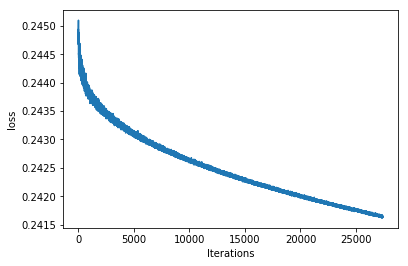

[('loss', 0.24161962)]
[('loss', 0.24164295)]
[('loss', 0.24162903)]
[('loss', 0.24162637)]
[('loss', 0.2416284)]
[('loss', 0.24165007)]
[('loss', 0.24162127)]
[('loss', 0.24163571)]
[('loss', 0.24164009)]
[('loss', 0.24162115)]


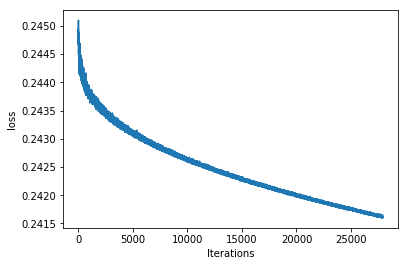

[('loss', 0.24162024)]
[('loss', 0.24163842)]
[('loss', 0.2416264)]
[('loss', 0.24160032)]
[('loss', 0.24161094)]
[('loss', 0.24160627)]
[('loss', 0.24159496)]
[('loss', 0.24159749)]
[('loss', 0.24159461)]
[('loss', 0.24159788)]


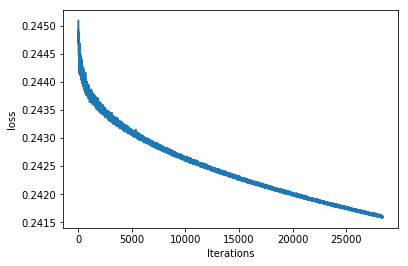

[('loss', 0.24160054)]
[('loss', 0.24160059)]
[('loss', 0.24159908)]
[('loss', 0.24157628)]
[('loss', 0.24159867)]
[('loss', 0.24158072)]
[('loss', 0.241573)]
[('loss', 0.2415848)]
[('loss', 0.2415883)]
[('loss', 0.24158806)]


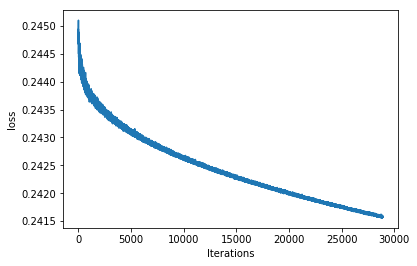

[('loss', 0.24157992)]
[('loss', 0.24155833)]
[('loss', 0.24156897)]
[('loss', 0.24156623)]
[('loss', 0.24156712)]
[('loss', 0.24158186)]
[('loss', 0.24155769)]
[('loss', 0.241549)]
[('loss', 0.24155395)]
[('loss', 0.24154775)]


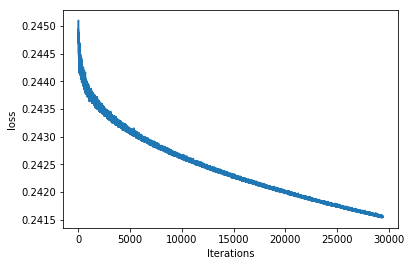

[('loss', 0.24154715)]
[('loss', 0.24155967)]
[('loss', 0.24155115)]
[('loss', 0.24154395)]
[('loss', 0.24154472)]
[('loss', 0.24154422)]
[('loss', 0.2415398)]
[('loss', 0.24151848)]
[('loss', 0.2415415)]
[('loss', 0.24153033)]


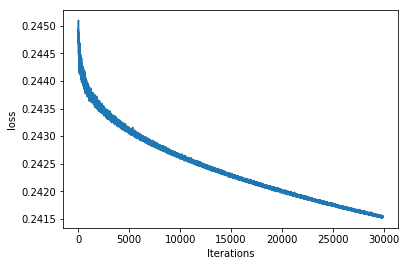

[('loss', 0.24152169)]
[('loss', 0.24152069)]
[('loss', 0.24153529)]
[('loss', 0.24151434)]
[('loss', 0.24151355)]
[('loss', 0.24151751)]
[('loss', 0.24152483)]
[('loss', 0.24151662)]
[('loss', 0.2415059)]
[('loss', 0.24149823)]


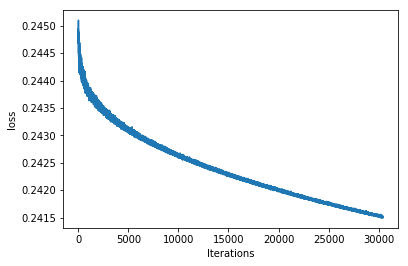

[('loss', 0.24149601)]
[('loss', 0.24150857)]
[('loss', 0.2415207)]
[('loss', 0.24149331)]
[('loss', 0.24149199)]
[('loss', 0.2415098)]
[('loss', 0.24148567)]
[('loss', 0.2414953)]
[('loss', 0.24148715)]
[('loss', 0.24149188)]


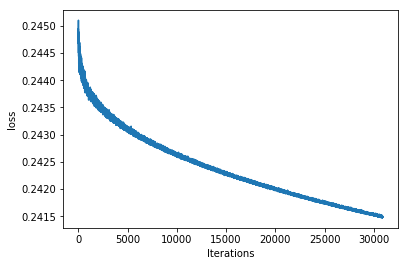

[('loss', 0.24148832)]
[('loss', 0.24148719)]
[('loss', 0.24149244)]
[('loss', 0.24148604)]
[('loss', 0.24146679)]
[('loss', 0.24148451)]
[('loss', 0.24147756)]
[('loss', 0.24147516)]
[('loss', 0.2414677)]
[('loss', 0.24147713)]


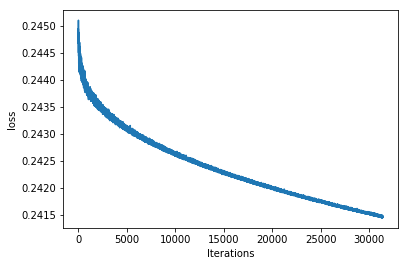

[('loss', 0.24147396)]
[('loss', 0.24145201)]
[('loss', 0.24147022)]
[('loss', 0.24146472)]
[('loss', 0.2414702)]
[('loss', 0.24144629)]
[('loss', 0.24144505)]
[('loss', 0.24145237)]
[('loss', 0.24145253)]
[('loss', 0.24144861)]


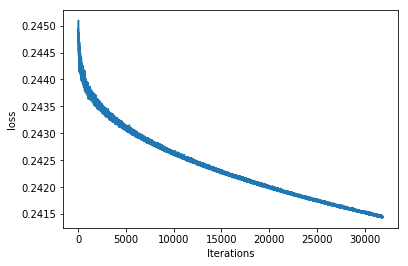

[('loss', 0.24145024)]
[('loss', 0.24144873)]
[('loss', 0.2414438)]
[('loss', 0.24143648)]
[('loss', 0.24143343)]
[('loss', 0.2414429)]
[('loss', 0.24143839)]
[('loss', 0.24143562)]
[('loss', 0.24146016)]
[('loss', 0.2414359)]


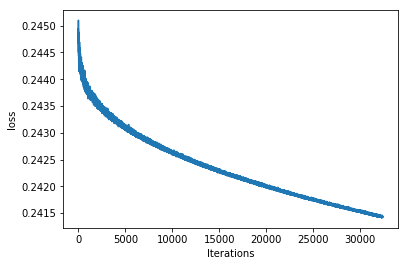

[('loss', 0.2414145)]
[('loss', 0.24142157)]
[('loss', 0.24144137)]
[('loss', 0.24142492)]
[('loss', 0.24140644)]
[('loss', 0.24142714)]
[('loss', 0.24141921)]
[('loss', 0.2414119)]
[('loss', 0.24141851)]
[('loss', 0.24140711)]


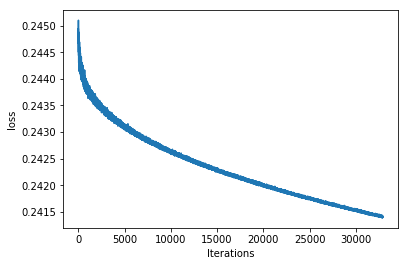

[('loss', 0.24140617)]
[('loss', 0.24140589)]
[('loss', 0.24139969)]
[('loss', 0.24140316)]
[('loss', 0.2414028)]
[('loss', 0.2414039)]
[('loss', 0.24138527)]
[('loss', 0.24139355)]
[('loss', 0.24138585)]
[('loss', 0.24139126)]


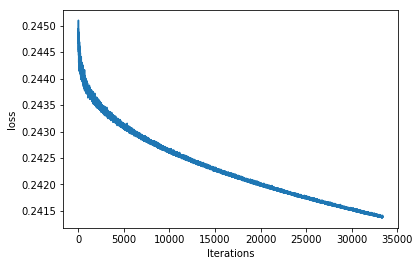

[('loss', 0.24140103)]
[('loss', 0.24140263)]
[('loss', 0.2413813)]
[('loss', 0.24137427)]
[('loss', 0.24137463)]
[('loss', 0.24138848)]
[('loss', 0.24137142)]
[('loss', 0.24135727)]
[('loss', 0.24136914)]
[('loss', 0.24137066)]


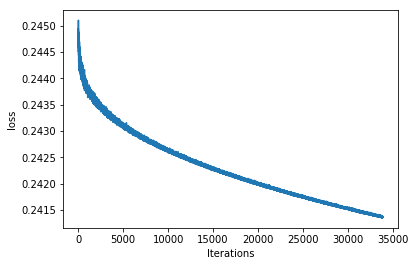

[('loss', 0.24136466)]
[('loss', 0.24135262)]
[('loss', 0.24136893)]
[('loss', 0.24134505)]
[('loss', 0.24136141)]
[('loss', 0.2413551)]
[('loss', 0.24134465)]
[('loss', 0.24134968)]
[('loss', 0.24135885)]
[('loss', 0.24136326)]


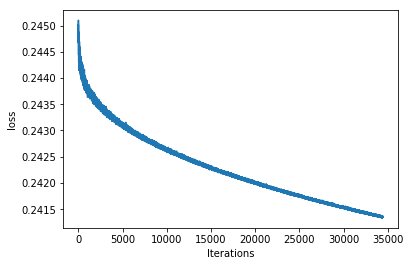

[('loss', 0.2413616)]
[('loss', 0.24134322)]
[('loss', 0.24133816)]
[('loss', 0.24134205)]
[('loss', 0.24132828)]
[('loss', 0.24134618)]
[('loss', 0.2413437)]
[('loss', 0.2413286)]
[('loss', 0.24133666)]
[('loss', 0.24132027)]


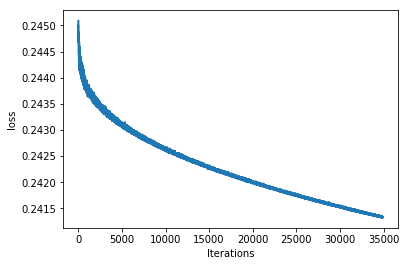

[('loss', 0.24133389)]
[('loss', 0.24132179)]
[('loss', 0.24133849)]
[('loss', 0.2413197)]
[('loss', 0.24131176)]
[('loss', 0.24131311)]
[('loss', 0.24131635)]
[('loss', 0.24130777)]
[('loss', 0.24131128)]
[('loss', 0.24132486)]


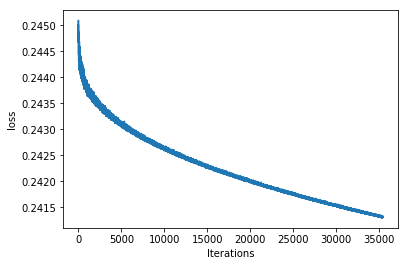

[('loss', 0.24129741)]
[('loss', 0.24129727)]
[('loss', 0.24129243)]
[('loss', 0.24129623)]
[('loss', 0.24129623)]
[('loss', 0.2412962)]
[('loss', 0.2412995)]
[('loss', 0.24129541)]
[('loss', 0.24128778)]
[('loss', 0.2412984)]


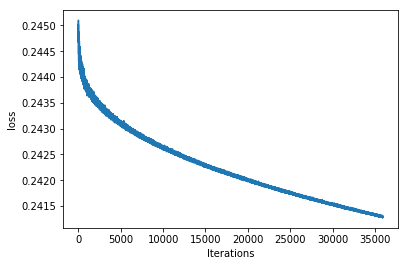

[('loss', 0.24130626)]
[('loss', 0.24128231)]
[('loss', 0.24128753)]
[('loss', 0.24128592)]
[('loss', 0.2412891)]
[('loss', 0.2412715)]
[('loss', 0.24127291)]
[('loss', 0.24127856)]
[('loss', 0.2412927)]
[('loss', 0.24128112)]


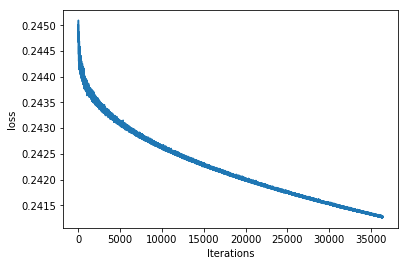

[('loss', 0.24126664)]
[('loss', 0.24128492)]
[('loss', 0.24127673)]
[('loss', 0.2412691)]
[('loss', 0.24127652)]
[('loss', 0.24126264)]
[('loss', 0.2412704)]
[('loss', 0.24125443)]
[('loss', 0.24125342)]
[('loss', 0.2412554)]


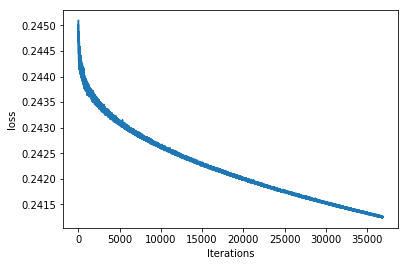

[('loss', 0.24125344)]
[('loss', 0.2412533)]
[('loss', 0.24125727)]
[('loss', 0.2412548)]
[('loss', 0.24124974)]
[('loss', 0.2412464)]
[('loss', 0.2412331)]
[('loss', 0.24124682)]
[('loss', 0.24124198)]
[('loss', 0.24123096)]


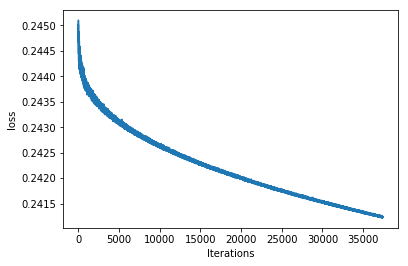

[('loss', 0.24123177)]
[('loss', 0.24123895)]
[('loss', 0.24123032)]
[('loss', 0.24123253)]
[('loss', 0.24121909)]
[('loss', 0.24121338)]
[('loss', 0.24121562)]
[('loss', 0.24120778)]
[('loss', 0.2412317)]
[('loss', 0.24122086)]


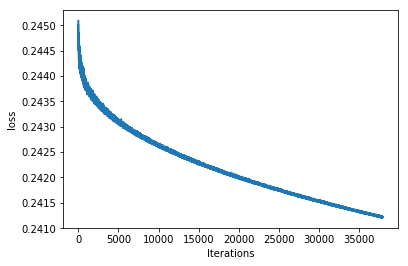

[('loss', 0.24121217)]
[('loss', 0.24120736)]
[('loss', 0.24121128)]
[('loss', 0.24122776)]
[('loss', 0.24119426)]
[('loss', 0.24119839)]
[('loss', 0.2412045)]
[('loss', 0.24120994)]
[('loss', 0.24120799)]
[('loss', 0.24119738)]


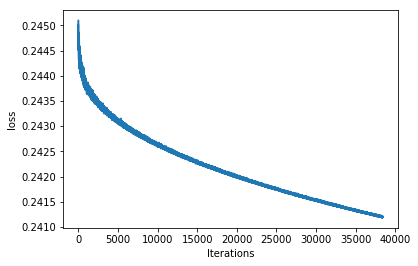

[('loss', 0.24118386)]
[('loss', 0.24122097)]
[('loss', 0.2412002)]
[('loss', 0.24120274)]
[('loss', 0.24117686)]
[('loss', 0.24117266)]
[('loss', 0.24117374)]
[('loss', 0.24118136)]
[('loss', 0.24118261)]
[('loss', 0.24117734)]


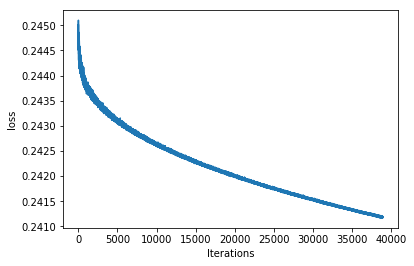

[('loss', 0.24118535)]
[('loss', 0.2411662)]
[('loss', 0.24117655)]
[('loss', 0.24117793)]
[('loss', 0.24117413)]
[('loss', 0.24116105)]
[('loss', 0.24116205)]
[('loss', 0.2411581)]
[('loss', 0.24118415)]
[('loss', 0.24115485)]


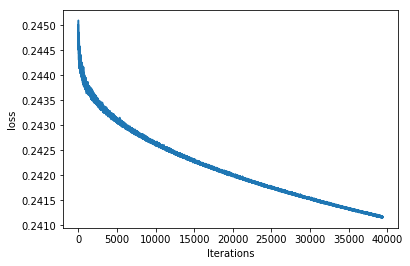

[('loss', 0.2411713)]
[('loss', 0.24115527)]
[('loss', 0.24115194)]
[('loss', 0.24115358)]
[('loss', 0.24115913)]
[('loss', 0.24114926)]
[('loss', 0.24114926)]
[('loss', 0.24114084)]
[('loss', 0.24113837)]
[('loss', 0.24114633)]


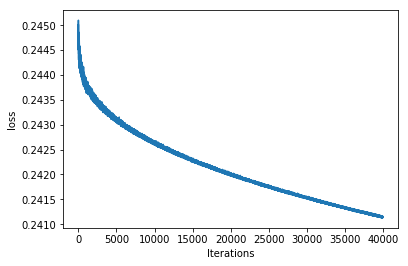

[('loss', 0.2411503)]
[('loss', 0.24115235)]
[('loss', 0.24113166)]
[('loss', 0.24112493)]
[('loss', 0.24113408)]
[('loss', 0.24112628)]
[('loss', 0.241131)]
[('loss', 0.24112636)]
[('loss', 0.24111974)]
[('loss', 0.24112636)]


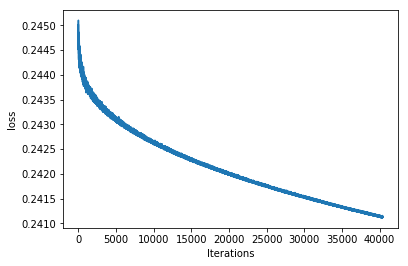

[('loss', 0.24112254)]
[('loss', 0.24110854)]
[('loss', 0.24110575)]
[('loss', 0.24110696)]
[('loss', 0.24113186)]
[('loss', 0.2411253)]
[('loss', 0.2411221)]
[('loss', 0.24111381)]
[('loss', 0.24110286)]
[('loss', 0.24110273)]


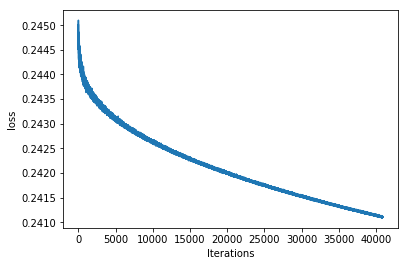

[('loss', 0.24110985)]
[('loss', 0.2411117)]
[('loss', 0.24109937)]
[('loss', 0.24109836)]
[('loss', 0.24110524)]
[('loss', 0.24109755)]
[('loss', 0.24110201)]
[('loss', 0.24111006)]
[('loss', 0.24107811)]
[('loss', 0.24108404)]


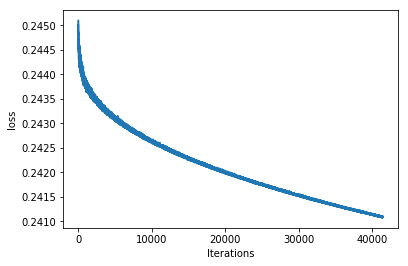

[('loss', 0.24109377)]
[('loss', 0.24110457)]
[('loss', 0.24108309)]
[('loss', 0.24107897)]
[('loss', 0.24108692)]
[('loss', 0.2410896)]
[('loss', 0.24106802)]
[('loss', 0.24108353)]
[('loss', 0.24107274)]
[('loss', 0.2410722)]


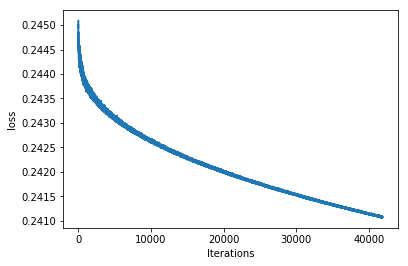

[('loss', 0.24105462)]
[('loss', 0.2410655)]
[('loss', 0.24107033)]
[('loss', 0.24105173)]
[('loss', 0.24104571)]
[('loss', 0.2410619)]
[('loss', 0.24105997)]
[('loss', 0.24106939)]
[('loss', 0.24106218)]
[('loss', 0.24103875)]


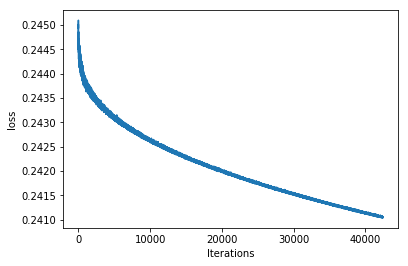

[('loss', 0.24104999)]
[('loss', 0.24105759)]
[('loss', 0.24104701)]
[('loss', 0.24105316)]
[('loss', 0.24104166)]
[('loss', 0.24104744)]
[('loss', 0.24104667)]
[('loss', 0.24104445)]
[('loss', 0.24103597)]
[('loss', 0.24102779)]


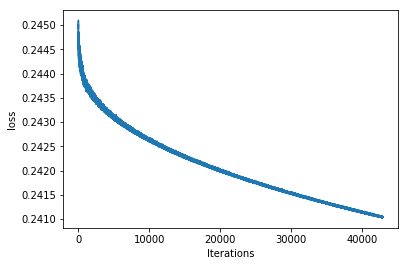

[('loss', 0.24103747)]
[('loss', 0.24104577)]
[('loss', 0.24103503)]
[('loss', 0.24103798)]
[('loss', 0.24101812)]
[('loss', 0.24102692)]
[('loss', 0.2410331)]
[('loss', 0.24103166)]
[('loss', 0.2410249)]
[('loss', 0.24102439)]


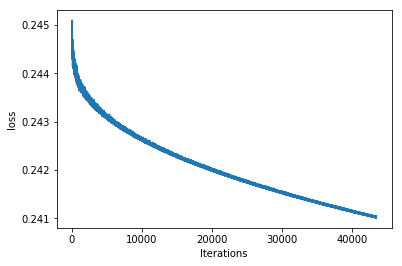

[('loss', 0.24102168)]
[('loss', 0.24102207)]
[('loss', 0.24101081)]
[('loss', 0.24100758)]
[('loss', 0.24102037)]
[('loss', 0.24100032)]
[('loss', 0.24101637)]
[('loss', 0.2409976)]
[('loss', 0.24100588)]
[('loss', 0.24100111)]


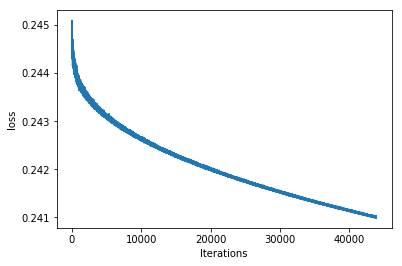

[('loss', 0.24100125)]
[('loss', 0.24100317)]
[('loss', 0.24099234)]
[('loss', 0.24099612)]
[('loss', 0.24100435)]
[('loss', 0.24099484)]
[('loss', 0.24099417)]
[('loss', 0.24098867)]
[('loss', 0.24098063)]
[('loss', 0.24098681)]


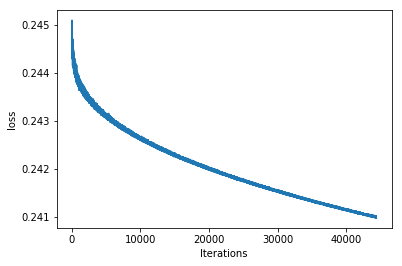

[('loss', 0.24098113)]
[('loss', 0.24098453)]
[('loss', 0.24099118)]
[('loss', 0.24098669)]
[('loss', 0.2409789)]
[('loss', 0.2409701)]
[('loss', 0.24097279)]
[('loss', 0.24098033)]
[('loss', 0.24096167)]
[('loss', 0.24097274)]


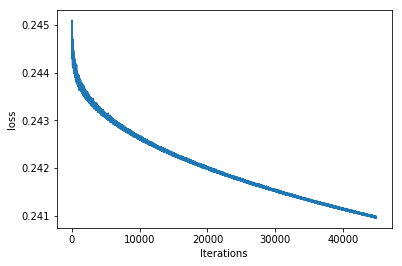

[('loss', 0.24097092)]
[('loss', 0.24096353)]
[('loss', 0.24096043)]
[('loss', 0.24097744)]
[('loss', 0.24095602)]
[('loss', 0.24095923)]
[('loss', 0.24097003)]
[('loss', 0.24095972)]
[('loss', 0.24094932)]
[('loss', 0.24094586)]


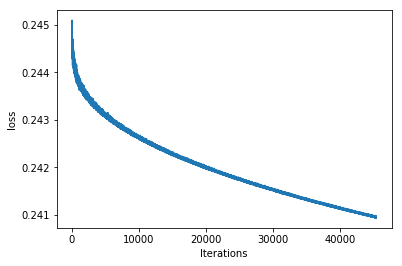

[('loss', 0.24095361)]
[('loss', 0.2409451)]
[('loss', 0.24094221)]
[('loss', 0.2409474)]
[('loss', 0.24094047)]
[('loss', 0.2409394)]
[('loss', 0.24093913)]
[('loss', 0.2409504)]
[('loss', 0.24093755)]
[('loss', 0.24093696)]


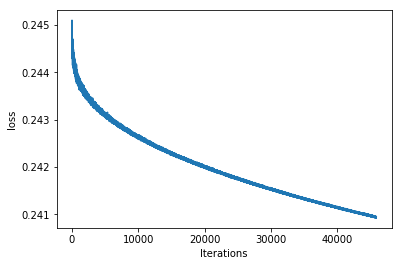

[('loss', 0.24093235)]
[('loss', 0.24094146)]
[('loss', 0.24091965)]
[('loss', 0.24092874)]
[('loss', 0.24092321)]
[('loss', 0.24093473)]
[('loss', 0.24092895)]
[('loss', 0.24092886)]
[('loss', 0.24091882)]
[('loss', 0.2409139)]


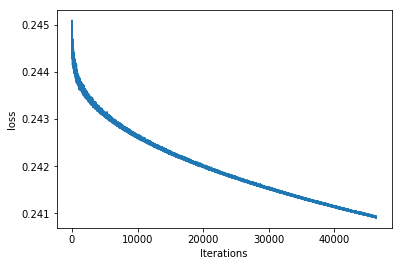

[('loss', 0.24091627)]
[('loss', 0.24091518)]
[('loss', 0.24090564)]
[('loss', 0.24091312)]
[('loss', 0.24091095)]
[('loss', 0.24090953)]
[('loss', 0.24089894)]
[('loss', 0.24091814)]
[('loss', 0.2409109)]
[('loss', 0.24090464)]


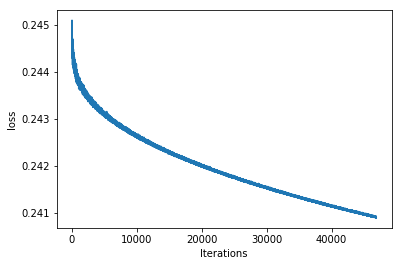

[('loss', 0.24089864)]
[('loss', 0.24089444)]
[('loss', 0.24091223)]
[('loss', 0.24090621)]
[('loss', 0.24088994)]
[('loss', 0.2408857)]
[('loss', 0.2408921)]
[('loss', 0.24089572)]
[('loss', 0.24088447)]
[('loss', 0.24088073)]


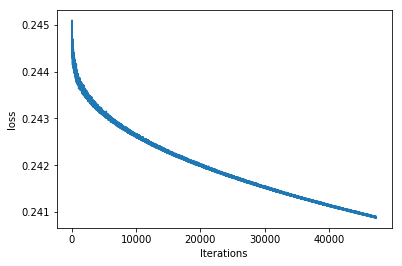

[('loss', 0.240892)]
[('loss', 0.24088223)]
[('loss', 0.2408804)]
[('loss', 0.24087583)]
[('loss', 0.24086696)]
[('loss', 0.24087808)]
[('loss', 0.24086507)]
[('loss', 0.2408783)]
[('loss', 0.24086154)]
[('loss', 0.24086274)]


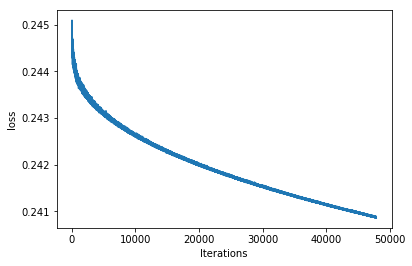

[('loss', 0.24088345)]
[('loss', 0.24085733)]
[('loss', 0.24088281)]
[('loss', 0.24086554)]
[('loss', 0.24085711)]
[('loss', 0.24085516)]
[('loss', 0.24087131)]
[('loss', 0.24085622)]
[('loss', 0.24086232)]
[('loss', 0.24085537)]


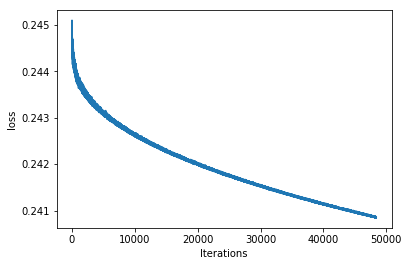

[('loss', 0.24084337)]
[('loss', 0.24085636)]
[('loss', 0.2408549)]
[('loss', 0.24084581)]
[('loss', 0.24084872)]
[('loss', 0.24084122)]
[('loss', 0.2408284)]
[('loss', 0.24084495)]
[('loss', 0.24084868)]
[('loss', 0.24085344)]


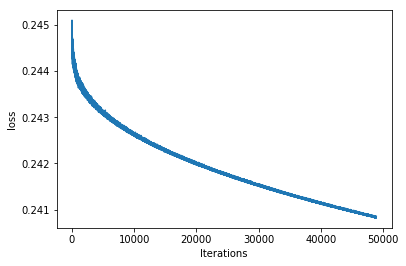

[('loss', 0.24083024)]
[('loss', 0.24083373)]
[('loss', 0.24083604)]
[('loss', 0.24082603)]
[('loss', 0.24082631)]
[('loss', 0.24082641)]
[('loss', 0.2408277)]
[('loss', 0.24081191)]
[('loss', 0.24082664)]
[('loss', 0.24083611)]


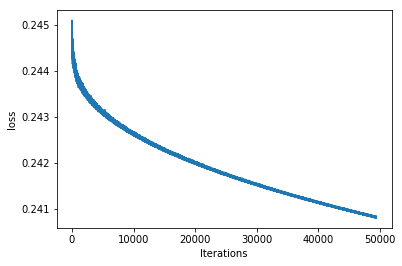

[('loss', 0.24081564)]
[('loss', 0.24082546)]
[('loss', 0.2408072)]
[('loss', 0.24080566)]
[('loss', 0.24080372)]
[('loss', 0.24081397)]
[('loss', 0.24081926)]
[('loss', 0.24081965)]
[('loss', 0.24080344)]


In [62]:
val_log = None
update = "adt_brsg"
# update = "trans"
# update = "true_qs"
# update = "adt"
i = 0
while i < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    t = len(full_train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, t=t, true_qs=true_qs)        
    if i % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, t=t, true_qs=true_qs)
        for k, v in train_log.items():
            full_train_logs['%s_evals' % k].append(v)
        for k, v in val_log.items():
            full_train_logs['val_%s_evals' % k].append(v)    
    
    if i % 1000 == 0:
#         print(t, val_log['loss'])
          print([(key,val_log[key]) for key in val_log.keys()])
    if i % 10000 == 0:
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][100:])
                plt.show()
    i += 1

In [53]:
tts = np.arange(2)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]

In [54]:
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [55]:
adt_samples

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4]])

In [56]:
softmax(adt_probs)

array([[0.794138  , 0.09032027, 0.01819601, 0.09554142, 0.00180433],
       [0.06778116, 0.8307664 , 0.08568345, 0.01576893, 0.00000002],
       [0.03039555, 0.15315296, 0.78332156, 0.03312991, 0.        ],
       [0.09547988, 0.0000002 , 0.09672853, 0.8016317 , 0.00615977],
       [0.0000279 , 0.        , 0.00000109, 0.00178676, 0.99818426],
       [0.00008049, 0.        , 0.00000084, 0.00011247, 0.9998062 ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]],
      dtype=float32)

In [ ]:
print(reward_map)

In [58]:
states = featurize_states(np.arange(mdp.nS))
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
# i,n=200,30
# states, actions = nn_rollouts[1][i:i+n], nn_rollouts[2][i:i+n] #featurize_states(np.arange(mdp.nS))
# q_vals, likelihoods, qsas, vs = sess.run([demo_q_t, act_log_likelihoods,tf.gather_nd(demo_q_t, action_indexes), demo_v_t],
#                                feed_dict={demo_obs_t_feats_ph:states,
#                                             demo_act_t_ph:actions,
#                                             demo_batch_size_ph: n})

In [ ]:
# evals = [constraint_q_ts, constraint_adt_pred_probs, constraint_adt_pred_dir, adt_target_t, ca_indexes, cqtp1_misshaped, constraint_q_tp1, constraint_v_tp1, constraint_sprimes_reshaped, adt_V]
# c_qs, pred_probs, pred_dirs, adt_targs, acties, cq1, cq2, cv, cspr, av, tqes  = sess.run(evals,
#                         feed_dict={constraint_obs_t_feats_ph: constraints[0],
#                                     constraint_act_t_ph: constraints[1],
#                                     constraint_rew_t_ph: constraints[2],
#                                     constraint_next_obs_t_feats_ph: constraints[3],
#                                     constraint_tile_t_ph: constraints[4],
#                                     constraint_batch_size_ph: constraints[0].shape[0],
#                                     true_qs_ph: true_qs})

evals = [adt_V_sg, adt_target_sg, constraint_q_t]
av, at, cqt = sess.run(evals,
                        feed_dict={constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    true_qs_ph: true_qs})

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], true_qs[t_ind], tqes[t_ind] #, adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind]

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], true_qs[t_ind], tqes[t_ind] #, adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind]

In [ ]:
constraints[0][0:3], constraints[1][0:3], av[0:3], at[0:3], cqt[0:3]

In [ ]:
av.shape, at.shape, cqt.shape

In [ ]:
np.where((constraints[0] == np.array([4,1])).all(axis=1))

In [ ]:
t_ind = 337

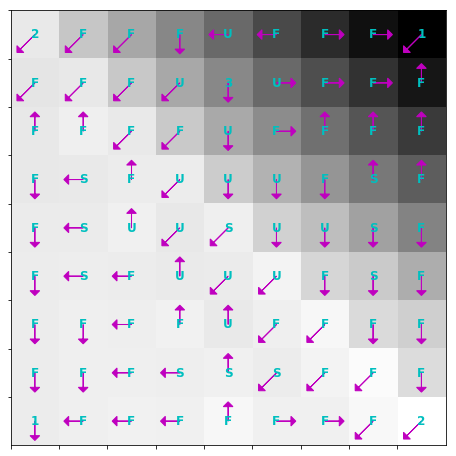

In [60]:
plot_values(mdp, q_vals)

In [ ]:
Qs = tabsoftq_learn_Qs(mdp)

In [ ]:
plot_values(mdp, Qs)

In [59]:
q_vals

array([[ 0.05721106,  0.05918467,  0.056909  ,  0.0538825 ,  0.06329427],
       [ 0.03626443,  0.03765233,  0.03653219,  0.03763581,  0.03802686],
       [ 0.01431611,  0.01503371,  0.01432658,  0.01489182,  0.01521605],
       [-0.00763221, -0.00758491, -0.00787903, -0.00785217, -0.00759477],
       [-0.02958053, -0.03020353, -0.03008463, -0.03059615, -0.03040559],
       [-0.05152886, -0.05282215, -0.05229025, -0.05334015, -0.0532164 ],
       [-0.07360992, -0.0743993 , -0.07356644, -0.07479137, -0.07574865],
       [-0.09419733, -0.09388999, -0.09368168, -0.0944391 , -0.09616029],
       [-0.10526879, -0.10536293, -0.10532118, -0.10588577, -0.10521114],
       [ 0.06004496,  0.05711238,  0.05641496,  0.05979511,  0.06006381],
       [ 0.05817715,  0.05559342,  0.05899967,  0.06142165,  0.06235382],
       [ 0.03677946,  0.03868562,  0.03782998,  0.03850317,  0.03893275],
       [ 0.01483114,  0.016067  ,  0.01562437,  0.01575918,  0.01612193],
       [-0.00711718, -0.00655162, -0.0

In [ ]:
test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [ ]:
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = Qs[states,acts]
nextQs = Qs[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]

test_err, learned_err, targets = sess.run([test_adt_td_err, adt_td_err_sg, test_adt_target], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)

In [ ]:
q_net_path = os.path.join(data_dir, 'adt_q_max_16384.tf')
save_tf_vars(sess, q_scope, q_net_path)

invadt_path = os.path.join(data_dir, 'adt_invadt_max_16384.tf')
save_tf_vars(sess, invadt_scope, invadt_path)
# load_tf_vars(sess, invdyn_scope, invdyn_nr_path)



In [ ]:
pkl.dump(full_train_logs, open('adt_16384_max.pkl', 'wb'))